# GridSearch for Hyperparameter

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
)

In [2]:
# load dataset
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# percentage of benign (0) and malign tumors (1)

y.value_counts() / len(y)

0    0.627417
1    0.372583
dtype: float64

In [4]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

# Grid Search

Let's use gridsearch to find the ebst hyperparameters for a gradient boosting classifier

In [5]:
#set up model
gbm = GradientBoostingClassifier(random_state=0)

#determine hyperparameter space

param_grid = dict(
    n_estimators=[10, 20, 50, 100],
    min_samples_split=[0.1, 0.3, 0.5],
    max_depth=[1,2,3,4,None],
    )

print('Number of hyperparam combinations: ', 
      len(param_grid['n_estimators'])
      *len(param_grid['min_samples_split'])
      *len(param_grid['max_depth']))


Number of hyperparam combinations:  60


In [6]:
# set up the search
search = GridSearchCV(gbm, param_grid, scoring='roc_auc', cv=5, refit=True)

# find best hyperparameters
search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'max_depth': [1, 2, 3, 4, None],
                         'min_samples_split': [0.1, 0.3, 0.5],
                         'n_estimators': [10, 20, 50, 100]},
             scoring='roc_auc')

In [7]:
# the best hyperparameters are stored in an attribute

search.best_params_

{'max_depth': 2, 'min_samples_split': 0.1, 'n_estimators': 100}

In [8]:
# we also find the data for all models evaluated

results = pd.DataFrame(search.cv_results_)

print(results.shape)

results.head()

(60, 16)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.038804,0.024203,0.009545,0.007625,1,0.1,10,"{'max_depth': 1, 'min_samples_split': 0.1, 'n_...",0.979000,0.953000,0.966000,0.983103,0.940136,0.964248,0.016026,58
1,0.038398,0.008587,0.004001,0.000633,1,0.1,20,"{'max_depth': 1, 'min_samples_split': 0.1, 'n_...",0.978333,0.952000,0.968667,0.986897,0.970068,0.971193,0.011607,52
2,0.068410,0.014848,0.003601,0.001200,1,0.1,50,"{'max_depth': 1, 'min_samples_split': 0.1, 'n_...",0.997000,0.963667,0.983333,0.993103,0.980272,0.983475,0.011647,33
3,0.163596,0.024097,0.005804,0.002924,1,0.1,100,"{'max_depth': 1, 'min_samples_split': 0.1, 'n_...",1.000000,0.974333,0.988667,0.997241,0.983673,0.988783,0.009298,18
4,0.014801,0.002714,0.003001,0.000001,1,0.3,10,"{'max_depth': 1, 'min_samples_split': 0.3, 'n_...",0.979000,0.953000,0.966000,0.983103,0.940136,0.964248,0.016026,58


In [9]:
# we can order the different models based on their performance
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

#We only select some columns
results[[
    'param_max_depth', 'param_min_samples_split', 'param_n_estimators',
    'mean_test_score', 'std_test_score',
]].head()

,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score
0,2,0.1,100,0.992415,0.006426
1,2,0.3,100,0.992013,0.006461
2,3,0.5,100,0.991949,0.006547
3,4,0.5,100,0.991620,0.007117
4,2,0.5,100,0.991545,0.006363


In [10]:
#Worst performing model 
results[[
    'param_max_depth', 'param_min_samples_split', 'param_n_estimators',
    'mean_test_score', 'std_test_score',
]].tail()

,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score
55,2,0.3,10,0.971111,0.011933
56,2,0.5,10,0.965857,0.009779
57,1,0.3,10,0.964248,0.016026
58,1,0.5,10,0.964248,0.016026
59,1,0.1,10,0.964248,0.016026


Text(0.5, 0, 'Hyperparameter combinations')

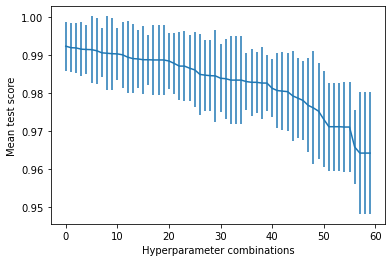

In [11]:
# plot model performance and error

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

We can directly make prediction because we set refit = True so the model is already fitted with the best hyperparameter

In [12]:
X_train_preds = search.predict_proba(X_train)[:,1]
X_test_preds = search.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))

Train roc_auc:  1.0
Test roc_auc:  0.996766607877719


With the train roc_auc equals to 1 in the train set we shoud suspect some form of overfitting.

Now we can start examining the performance of the model based on **individual parameters**. So, how much the value of each parameter affect the performance of the model. To do this we create a function to summarize the performance of the model.

In [13]:
# let's make a function to evaluate the model performance based on
# single hyperparameters

def summarize_by_param(hparam):
    
    tmp = pd.concat([
        results.groupby(hparam)['mean_test_score'].mean(),
        results.groupby(hparam)['mean_test_score'].std(),
    ], axis=1)

    tmp.columns = ['mean_test_score', 'std_test_score']
    
    return tmp

In [14]:
# performance change for n_estimators

tmp = summarize_by_param('param_n_estimators')

tmp.head()

,mean_test_score,std_test_score
param_n_estimators,,
10,0.973359,0.006228
20,0.980845,0.005222
50,0.987409,0.002550
100,0.990123,0.002078


Text(0, 0.5, 'roc-auc')

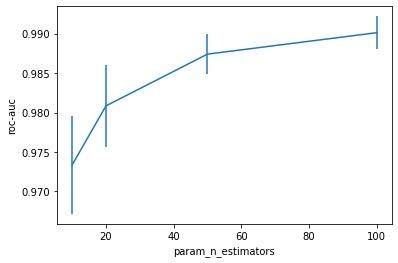

In [16]:
tmp['mean_test_score'].plot(yerr=[tmp['std_test_score'], tmp['std_test_score']], subplots=True)
plt.ylabel('roc-auc')

Here we can get an ide of the space with the best performace. And we can see that for this parameter the best performance lies somewhere in between 60 and 100.

Text(0, 0.5, 'roc-auc')

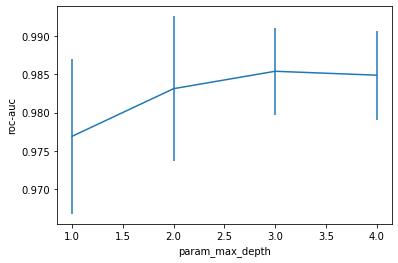

In [17]:
tmp = summarize_by_param('param_max_depth')
tmp['mean_test_score'].plot(yerr=[tmp['std_test_score'], tmp['std_test_score']], subplots=True)
plt.ylabel('roc-auc')

The best hyperparameters seems to be between 2 and 3.

array([<AxesSubplot:xlabel='param_min_samples_split'>], dtype=object)

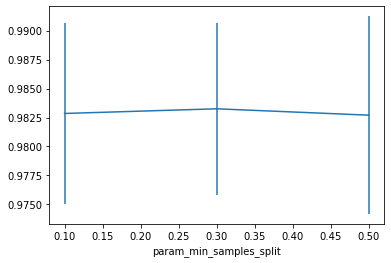

In [18]:
tmp = summarize_by_param('param_min_samples_split')
tmp['mean_test_score'].plot(yerr=[tmp['std_test_score'], tmp['std_test_score']], subplots=True)

This parameter does not seem to improve performance much.

Now we can further explore and fine tune these hyperparameters and try other hyperparameters that could be more significant.

In [19]:
# determine the hyperparameter space
param_grid = dict(
    n_estimators=[60, 80, 100, 120],
    max_depth=[2,3],
    loss = ['deviance', 'exponential'],
    )

# set up the search
search = GridSearchCV(gbm, param_grid, scoring='roc_auc', cv=5, refit=True)

# find best hyperparameters
search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'loss': ['deviance', 'exponential'],
                         'max_depth': [2, 3],
                         'n_estimators': [60, 80, 100, 120]},
             scoring='roc_auc')

In [20]:
# the best hyperparameters are stored in an attribute

search.best_params_

{'loss': 'exponential', 'max_depth': 2, 'n_estimators': 120}

In [21]:
results = pd.DataFrame(search.cv_results_)

results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results[[
    'param_max_depth', 'param_loss', 'param_n_estimators',
    'mean_test_score', 'std_test_score',
]].head(8)


,param_max_depth,param_loss,param_n_estimators,mean_test_score,std_test_score
0,2,exponential,120,0.993095,0.006174
1,2,exponential,100,0.992828,0.006021
2,2,exponential,80,0.992765,0.006340
3,2,deviance,120,0.992556,0.006791
4,2,deviance,100,0.992149,0.006904
5,2,exponential,60,0.991210,0.007305
6,2,deviance,60,0.991066,0.006638
7,2,deviance,80,0.990797,0.006979


Text(0.5, 0, 'Hyperparameter combinations')

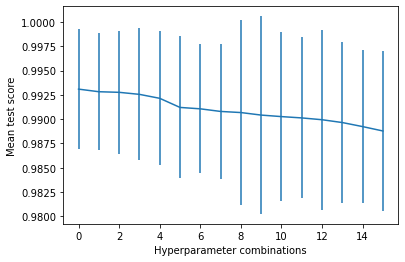

In [22]:
results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

In [23]:
X_train_preds = search.predict_proba(X_train)[:,1]
X_test_preds = search.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))

Train roc_auc:  0.9999999999999999
Test roc_auc:  0.9973544973544973
